In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
movies = pd.read_csv(r'Datasets\transformed_movies.csv')

In [7]:
movies = movies[['title','popularity','collection','genres_encoded']]

,title,popularity,collection,genres_encoded
0,Toy Story,21.946943,Toy Story Collection,"[2, 3, 7]"
1,Jumanji,17.015539,NaN,"[1, 8, 7]"
2,Grumpier Old Men,11.712900,Grumpy Old Men Collection,"[14, 3]"
3,Waiting to Exhale,3.859495,NaN,"[3, 6, 14]"
4,Father of the Bride Part II,8.387519,Father of the Bride Collection,[3]


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45376 entries, 0 to 45375
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           45376 non-null  object 
 1   popularity      45376 non-null  float64
 2   collection      4488 non-null   object 
 3   genres_encoded  45376 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


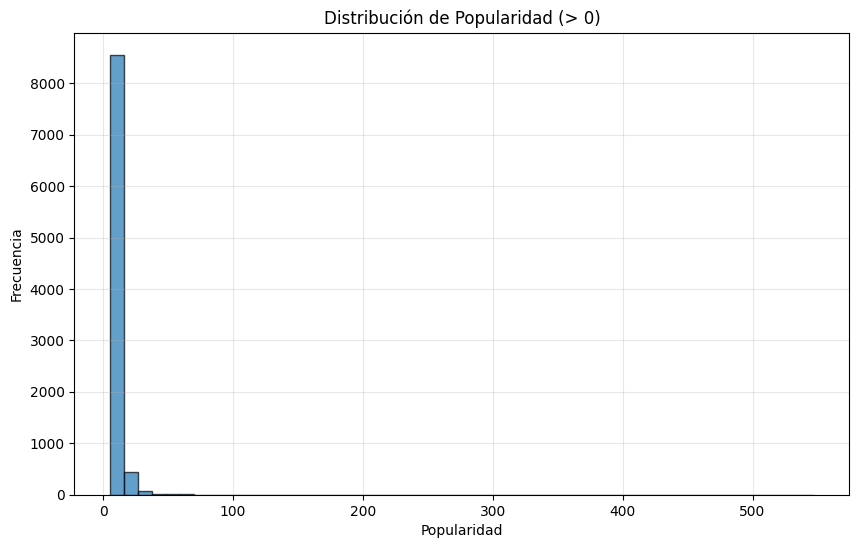

In [16]:
import matplotlib.pyplot as plt

# Filtrar datos
popularity_filtered = movies[movies['popularity'] > 5]['popularity']

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(popularity_filtered, bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribución de Popularidad (> 0)')
plt.xlabel('Popularidad')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()


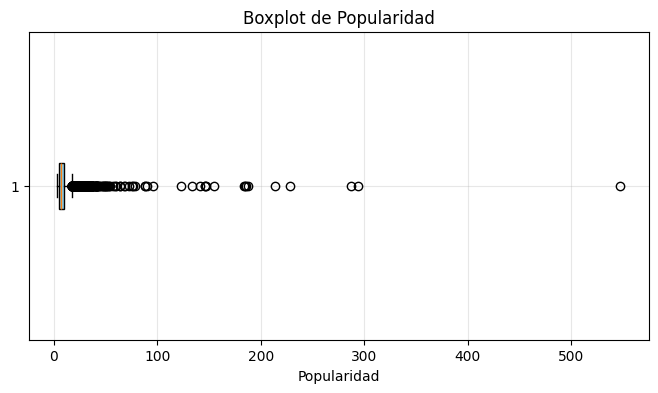

In [15]:
# Boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(popularity_filtered, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.title('Boxplot de Popularidad')
plt.xlabel('Popularidad')
plt.grid(True, alpha=0.3)
plt.show()


como no hay forma de que funcione la función recomendación, trabajo con una muestra calculada con la calculadoras de https://www.questionpro.com/es/calculadora-de-muestra.html

![calculadora](../Recomendacion_peliculas/assets/calculo%20de%20muestra.jpg)

In [23]:
# Crear una muestra aleatoria de 12186 registros
muestra_movies = movies.sample(n=12186, random_state=42)

# Verificar la cantidad de registros en la muestra
print(muestra_movies.shape)

# Mostrar las primeras filas de la muestra
print(muestra_movies.head())

muestra_movies.to_csv(r'Datasets/muestra_movies.csv', index=False)


(12186, 4)
                  title  popularity collection genres_encoded
32755     Among Friends    3.825472        NaN        [3, 11]
11208     Sorry, Haters    1.359754        NaN            [6]
18649              Gone    9.384244        NaN        [6, 17]
6231   The Three Marias    0.153388        NaN         [6, 9]
27836     The Overnight    7.834161        NaN        [13, 3]


In [21]:
# Crear una representación binaria de los géneros
mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(muestra_movies['genres_encoded'])

# Combinar con otras características como popularidad
movies_features = pd.DataFrame(genres_matrix, columns=mlb.classes_)
movies_features['popularity'] = muestra_movies['popularity']

# Rellenar los valores nulos en la columna de colecciones con 'No Collection'
muestra_movies['collection'] = muestra_movies['collection'].fillna('No Collection')

# Usar OneHotEncoder para las colecciones
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
collection_encoded = ohe.fit_transform(muestra_movies[['collection']])

# Crear un DataFrame con las colecciones codificadas
collection_df = pd.DataFrame(collection_encoded, columns=ohe.get_feature_names_out(['collection']))

# Combinar con la matriz de características existente
movies_features = pd.concat([movies_features, collection_df], axis=1)

# Escalar todas las características para que las colecciones no dominen
scaler = StandardScaler()
movies_features_scaled = scaler.fit_transform(movies_features)

# Crear un nuevo DataFrame escalado
movies_features_scaled = pd.DataFrame(movies_features_scaled, columns=movies_features.columns)

# Combinar todas las características en una sola matriz: combina géneros, popularidad y colecciones (ya procesadas con OneHotEncoding)
combined_features = np.hstack([movies_features.values, collection_encoded])

# Guardar la matriz en un archivo .npy
np.savez_compressed("Datasets/muestra_combined_features.npz", combined_features)




In [22]:
import numpy as np

# Cargar la matriz comprimida original
data = np.load("Datasets/muestra_combined_features.npz")['arr_0']

# Convertir la matriz a float32
data_optimized = data.astype(np.float32)

# Guardar la matriz optimizada en un nuevo archivo comprimido
np.savez_compressed("Datasets/muestra_features_optimized.npz", data_optimized)

print("Optimización completada. Nueva matriz guardada como 'muestra_features_optimized.npz'.")

Optimización completada. Nueva matriz guardada como 'muestra_features_optimized.npz'.
